In [449]:
#imports
from __future__ import division
import time
import datetime
from itertools import product
import operator
from collections import OrderedDict

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, r2_score

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [150]:
def load_data(dataset):
    if dataset == "breast cancer":
        dataLoad = datasets.load_breast_cancer(return_X_y=False)
        return {"data": dataBunch.data[:,:10],
                "target": dataBunch.target,
                "feature_names": dataBunch.feature_names[:10],
                "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])},
                "target_type": "Classification"
               }     
    elif dataset == "cervical cancer":
        dataLoad = pd.read_csv("data/cervical_cancer.csv")
        target = dataLoad.Biopsy
        dataLoad = dataLoad.drop(["Person", "Biopsy"],axis=1)
        return {"data": dataLoad.values,
                "target": target,
                "feature_names": dataLoad.columns,
                "feature_locs": {x:i for i,x in enumerate(dataLoad.columns)},
                "target_type": "Classification"
               }
    elif dataset == "bike":
        def _datestr_to_timestamp(s):
            return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

        dataLoad = pd.read_csv('data/bike.csv')
        dataLoad['dteday'] = dataLoad['dteday'].apply(_datestr_to_timestamp)
        dataLoad = pd.get_dummies(dataLoad, prefix=["weathersit"], columns=["weathersit"], drop_first=False)

        #de-normalize data to produce human-readable features.
        #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
        dataLoad["hum"] = dataLoad["hum"].apply(lambda x: x*100.)
        dataLoad["windspeed"] = dataLoad["windspeed"].apply(lambda x: x*67.)
        #convert Celsius to Fahrenheit
        dataLoad["temp"] = dataLoad["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
        dataLoad["atemp"] = dataLoad["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

        #rename features to make them interpretable for novice users
        feature_names_dict = {"yr":"First or Second Year", 
                                  "season":"Season", 
                                  "hr":"Hour of Day", 
                                  "workingday":"Work Day",
                                  "weathersit_2":"Misty Weather",
                                  "weathersit_3":"Light Precipitation",
                                  "weathersit_4":"Heavy Precipitation",
                                  "temp":"Temperature (F)",
                                  "atemp":"Feels Like (F)",
                                  "hum":"Humidity",
                                  "windspeed":"Wind Speed"}
        dataLoad= dataLoad.rename(mapper=feature_names_dict,axis=1) 
        features = feature_names_dict.values()

        return {"data": dataLoad[features].values,
                "target": dataLoad["cnt"],
                "feature_names": features,
                "feature_locs": {x:i for i,x in enumerate(features)},
                "target_type": "Regression"
               }     

In [698]:
def build_classifier(data, num_estimators, model_type, learning_rate):
    if data["target_type"] == "Classification":
        if model_type=="random forest":
            classifier_type = RandomForestClassifier
        elif model_type=="gradient boosting":
            classifier_type = GradientBoostingClassifier
    else:
        if model_type=="random forest":
            classifier_type = RandomForestRegressor
        elif model_type=="gradient boosting":
            classifier_type = GradientBoostingRegressor       
    classifier = classifier_type(n_estimators=num_estimators, max_depth=2, learning_rate=learning_rate, init=None)
    classifier.fit(data["data"], data["target"])
    predictions = classifier.predict(data["data"])
    score = accuracy_score(data["target"], predictions) if data["target_type"]== "Classification"\
    else r2_score(data["target"], predictions)
    return classifier, score

In [850]:
def calculate(data, classifier, num_tiles=20, collapse_1d = True, quantiles=False):
    
    def get_coordinate_matrix(lst, length, direction):
        if direction=="h":
            return lst*length
        else:
            return [item for item in lst\
             for i in range(length)]   

    def get_quantile_matrix(feat1, feat2):
        h = get_coordinate_matrix(list(feature_ranges[feat1]), len(feature_ranges[feat2]), "h")
        v = get_coordinate_matrix(list(feature_ranges[feat2]), len(feature_ranges[feat1]), "v")                      
        return h,v 

    def get_leaf_value(model, node_position):
        if data["target_type"]=="Classification":
            return model.tree_.value[node_position][0][1]/\
                        (model.tree_.value[node_position][0][1] + model.tree_.value[node_position][0][0])
        else:
#             print node_position
#             print model.tree_.value[node_position]
            return model.tree_.value[node_position]
        
    def get_feature_pair_key(feat1, feat2):
        if feature_ranges[feat1].shape[0] == feature_ranges[feat2].shape[0]:
            #need stable order so keys with same number of quantiles appear in only one order
            return tuple(sorted([feat1, feat2]))
        elif feature_ranges[feat1].shape[0]> feature_ranges[feat2].shape[0]:
            return tuple([feat1, feat2])
        else:
            return tuple([feat2, feat1])
        
    def get_quantiles(feat):
        loc = data["feature_locs"][feat]
        if np.unique(data["data"][:,loc]).shape[0] < 30 or type(data["data"][0,loc]) is str:
            return np.unique(data["data"][:,loc])
        else:
            if quantiles:
                return np.around(np.unique(np.quantile(a=data["data"][:,loc], q=np.linspace(0, 1, num_tiles))),1)
            else:
                return np.around(np.linspace(np.min(data["data"][:,loc]), np.max(data["data"][:,loc]), num_tiles),1)
    
    
    #get feature quantiles
    feature_ranges = {}
    for feature in data["feature_names"]:
        feature_ranges[feature] = get_quantiles(feature)
        
    #generate data structure for pairwise charts
    feature_pairs = {get_feature_pair_key(key[0], key[1]): {"map":None,
                                                            "bolShow": True,
                                                            "predicates":[]}\
                     for key in [tuple(t) for t in product(data["feature_names"], repeat=2)]}      
  
    for key, value in feature_pairs.iteritems():
        h, v = get_quantile_matrix(key[0], key[1])
        value["map"]=np.array([{key[0]:x, key[1]:y}\
                               for x,y in zip(h,v)])\
        .reshape(len(feature_ranges[key[0]]), len(feature_ranges[key[1]]))
        
    for modelT in classifier.estimators_:
        if data["target_type"] == "Regression":
            model = modelT[0]
        else:
            model = modelT
        feature_ids = {i:{"number":x, "name":data["feature_names"][x]}\
                          for i,x in enumerate(list(model.tree_.feature)) if x>=0} #-2 means leaf node

        #need to refactor this part to condense code and prepare for handling higher-depth trees

        #for 1-layer trees
        if model.tree_.feature[1] <0:
            print "1-layer tree"
            print key
            feature_pair_key = get_feature_pair_key(feature_ids[0]["name"], feature_ids[0]["name"])
            decision_func_dict = {
                "feature_name": feature_ids[0]["name"],
                "threshold": model.tree_.threshold[0],
                "operator": operator.le,
                "prob_le": get_leaf_value(model,1),
                "prob_gt": get_leaf_value(model,2)
            }       
            #build the predictive function used in the decision tree
            def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                if decision_func_dict["operator"](\
                                                    data_case[decision_func_dict["feature_name"]],\
                                                    decision_func_dict["threshold"]\
                                                   ):
                    return decision_func_dict["prob_le"]
                else:
                    return decision_func_dict["prob_gt"]        
        else:
            for node_position in [1,4]: #positions for left and right nodes at layer 2
                if node_position in feature_ids:
                    feature_pair_key = get_feature_pair_key(feature_ids[0]["name"], feature_ids[node_position]["name"])
                    #get the decision rules
                    decision_func_dict = {
                        "feature_name_1": feature_ids[0]["name"],
                        "threshold_1": model.tree_.threshold[0],

                        "operator_1": operator.le if node_position == 1 else operator.gt,

                        "feature_name_2": feature_ids[node_position]["name"],
                        "threshold_2": model.tree_.threshold[node_position],

                        "operator_2": operator.le,

                        "prob_le": get_leaf_value(model,node_position+1),

                        "prob_gt": get_leaf_value(model,node_position+2)
                    }
                    #print decision_func_dict
                    #build the predictive function used in the decision tree
                    def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                        #print data_case
                        #print decision_func_dict
                        if decision_func_dict["operator_1"](\
                                                            data_case[decision_func_dict["feature_name_1"]],\
                                                            decision_func_dict["threshold_1"]\
                                                           ):
                            #print "in1"
                            if decision_func_dict["operator_2"](\
                                                                data_case[decision_func_dict["feature_name_2"]],\
                                                                decision_func_dict["threshold_2"]\
                                                               ):
                                #print "in2"
                                return decision_func_dict["prob_le"]
                            else:
                                #print "in3"
                                return decision_func_dict["prob_gt"]
                        else:
                            return 0.

                else: #asymmetric tree, this is a leaf node
                    feature_pair_key = get_feature_pair_key(feature_ids[0]["name"], feature_ids[0]["name"])
                    decision_func_dict = {
                        "feature_name": feature_ids[0]["name"],
                        "threshold": model.tree_.threshold[0],
                        "operator": operator.le if node_position == 1 else operator.gt,
                        "prob": model.tree_.value[node_position]
                    }
                    #build the predictive function used in the decision tree
                    def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                        #print data_case
                        if decision_func_dict["operator"](\
                                                            data_case[decision_func_dict["feature_name"]],\
                                                            decision_func_dict["threshold"]\
                                                           ):
                            return decision_func_dict["prob"]
                        else:                         
                            return 0.                 

                feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)
            
    #now calculate output array for each feature pair
    for key, value in feature_pairs.iteritems():
        arrs = []
        for predicate in value["predicates"]:
            f = np.vectorize(predicate)
            arrs.append(f(value["map"]))
        if len(arrs) > 0:
            #details of vote aggreggation method for random forest
            #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
            value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)
        else:
            value["output"] = None
            
    #build chart data
    for key, value in feature_pairs.iteritems():
        h,v = get_quantile_matrix(key[0], key[1])
        value["H_Indices"] = h
        value["V_Indices"] = v
        value["Votes"] = value["output"].ravel() if value["output"] is not None else None
        
    output_details = {"offset":0.,
                      "no_predictor_features":[],
                      "1d_features":[],
                      "dropped_features":[]}
    chart_data = {}
    for key, value in feature_pairs.iteritems(): 
        if value["Votes"] is None:
            output_details["no_predictor_features"].append(key)
        else:          
            newKey = key
            if np.std(value["output"]-value["output"][0,:].reshape(1,-1))/np.max(np.abs(value["output"]))<=-0.1:
                print "a"
                value["Votes"] = value["output"][0,:].ravel()
                value["H_Indices"] = feature_ranges[key[1]]
                value["V_Indices"] = None
                newKey = key[1]
                output_details["1d_features"].append(key)
            elif np.std(value["output"]-value["output"][:,0].reshape(-1,1))/np.max(np.abs(value["output"]))<=-0.1:
                print "b"
                value["Votes"] = value["output"][:,0].ravel()
                value["H_Indices"] = feature_ranges[key[0]]
                value["V_Indices"] = None
                newKey = key[0]
                output_details["1d_features"].append(key)

            #subtract mean from votes to center at zero
            vote_mean = value["Votes"].mean()
            output_details["offset"] += vote_mean
            value["Votes"] = value["Votes"] - vote_mean
            #build dataframe for chart
            if value["V_Indices"] is not None:
                chart_data[key] = {"df":pd.DataFrame(dict((x, value[x])\
                                                          for x in ["H_Indices", "V_Indices", "Votes"])),
                                  "dimension":2}
            else:
                df = pd.DataFrame(dict((x, value[x]) for x in ["H_Indices", "Votes"]))
                if newKey in chart_data:
                    chart_data[newKey]["df"]["Votes"] = chart_data[newKey]["df"]["Votes"].add(df["Votes"])
                else:    
                    chart_data[newKey] = {"df": df, "dimension":1}

                    
    #do another loop through chart_data to push 1d charts into 2d
    if collapse_1d:
        for key, value in chart_data.iteritems():
            if value["dimension"] == 1:
                #get list of charts with this feature
                matchList = sorted([{"key": kInner, "feature_importance": np.std(vInner["df"].values)}\
                                    for kInner, vInner in chart_data.iteritems()\
                                    if vInner["dimension"] == 2 and key in kInner],\
                                   key=lambda x: x["feature_importance"], reverse=True)
                if len(matchList) > 0:
                    matchKey = matchList[0]["key"]
                    chart_data[key]["removed"] = True
                    match_length = int(chart_data[matchKey]["df"].shape[0]/value["df"].shape[0])
                    arr = np.array(get_coordinate_matrix(list(value["df"]["Votes"]), match_length,\
                                                         "v" if key==matchKey[1] else "h"))
#                     print key
#                     print matchKey
#                     print match_length
#                     print value["df"]
#                     print arr
                    chart_data[matchKey]["df"]["Votes"] = chart_data[matchKey]["df"]["Votes"] + arr.ravel()
                    
    #remove deleted keys
    chart_data = {key:val for key, val in chart_data.iteritems() if "removed" not in val}
    chart_data = OrderedDict(sorted(chart_data.items(), key=lambda x: np.std(x[1]["df"]["Votes"]), reverse=True))
    return chart_data, output_details

In [619]:
def generate_chart(data, raw_data, scheme="redyellowblue", plot_points=True):
    i = 1
    rows = []
    charts = []
    for key, value in data.iteritems():
            
        if value["dimension"] == 2:
            y_encoding = alt.Y(field="V_Indices",
                               type="ordinal", sort="descending",
                               axis=alt.Axis(title=key[1]))                

        x_encoding = alt.X(field="H_Indices",
                           type="ordinal", sort="ascending",
                           axis=alt.Axis(title=key[0] if value["dimension"] == 2 else key))

        color_encoding = alt.Color(field= "Votes",
                                   type="quantitative",
                                   scale=alt.Scale(scheme=scheme),
                                   legend=alt.Legend(title="Votes"))
        chart = alt.Chart(data=value["df"]).mark_rect()
        if value["dimension"] == 1:
            chart = chart.encode(x=x_encoding, color=color_encoding)\
                .properties(width=150, height=20)
        else:
             chart = chart.encode(x=x_encoding, y=y_encoding, color=color_encoding)\
                .properties(width=150, height=150)

        if plot_points:
            df = pd.DataFrame(raw_data["data"][np.random.choice(raw_data["data"].shape[0],300,replace=False),:],\
                              columns=raw_data["feature_names"])
            points = alt.Chart(df).mark_circle(
                color='black',
                size=5
            ).encode(
                x=alt.X(field=key[0],type="quantitative", sort="ascending", axis=None),
                y=alt.X(field=key[1],type="quantitative", sort="ascending", axis=None)
            ).properties(width=150, height=150)
            chart = chart + points
                
        charts.append(chart)
        if i%4==0 or i==len(data):
            rows.append(alt.hconcat(*charts))
            charts = []
        i += 1
    return alt.vconcat(*rows)

In [842]:
def evaluate(data, raw_data, classifier, chart_details):
    sample_size = 300
    sample_offset = 4000
    #predictions = np.full((raw_data["data"].shape[0],1),chart_details["offset"])
    predictions = np.full((sample_size,1),chart_details["offset"]+ 189.46308763450142)
    def get_predictions_from_chart(arr, chart_key):       
        df = data[chart_key]["df"]
#         print chart_key[0]
#         print arr[raw_data["feature_locs"][chart_key[0]]]
#         print chart_key[1]
#         print arr[raw_data["feature_locs"][chart_key[1]]]         
#         print df[(df["H_Indices"] <= arr[raw_data["feature_locs"][chart_key[0]]])\
#                           & (df["V_Indices"] <= arr[raw_data["feature_locs"][chart_key[1]]])]  
        try:
            return df[(df["H_Indices"] <= arr[raw_data["feature_locs"][chart_key[0]]])\
                      & (df["V_Indices"] <= arr[raw_data["feature_locs"][chart_key[1]]])].loc[:,"Votes"].iloc[-1]
        except:
            return df[(df["H_Indices"] <= arr[raw_data["feature_locs"][chart_key[0]]]*1.1)\
                      & (df["V_Indices"] <= arr[raw_data["feature_locs"][chart_key[1]]]*1.1)].loc[:,"Votes"].iloc[-1]
        
    for key in data.iterkeys():
        print key
        result = np.apply_along_axis(func1d=get_predictions_from_chart,
                                           axis=1,
                                           arr=raw_data["data"][sample_offset:sample_offset+sample_size,:],
                                           chart_key = key
                                          ).reshape(-1,1)
        predictions += result
#         print result
#         print predictions
    if raw_data["target_type"] == "Regression":
        #print "final"
        #print classifier.predict(raw_data["data"][sample_offset:sample_offset+sample_size,:])
        print r2_score(classifier.predict(raw_data["data"][sample_offset:sample_offset+sample_size,:]), predictions)

In [852]:
data_to_use = load_data("bike")
classifier, accuracy = build_classifier(data_to_use, 300, "gradient boosting", 1.0)
chart_data, output_details = calculate(data_to_use, classifier, 20, False)
generate_chart(chart_data, data_to_use)
evaluate(chart_data, data_to_use, classifier, output_details)

('Hour of Day', 'Hour of Day')
('Hour of Day', 'Temperature (F)')
('Hour of Day', 'Work Day')
('Hour of Day', 'First or Second Year')
('Feels Like (F)', 'Temperature (F)')
('Feels Like (F)', 'Heavy Precipitation')
('Hour of Day', 'Light Precipitation')
('Feels Like (F)', 'Wind Speed')
('Temperature (F)', 'Heavy Precipitation')
('Hour of Day', 'Feels Like (F)')
('Hour of Day', 'Heavy Precipitation')
('Feels Like (F)', 'Humidity')
('Temperature (F)', 'Wind Speed')
('Hour of Day', 'Wind Speed')
('Hour of Day', 'Humidity')
('Temperature (F)', 'Temperature (F)')
('Humidity', 'Wind Speed')
('Humidity', 'First or Second Year')
('Hour of Day', 'Season')
('Feels Like (F)', 'First or Second Year')
('Humidity', 'Temperature (F)')
('Humidity', 'Light Precipitation')
('Season', 'Light Precipitation')
('Feels Like (F)', 'Feels Like (F)')
('Temperature (F)', 'Light Precipitation')
('Wind Speed', 'Work Day')
('Humidity', 'Misty Weather')
('Humidity', 'Work Day')
('Feels Like (F)', 'Light Precipitation

In [737]:
data_to_use["feature_locs"]

{'Feels Like (F)': 2,
 'First or Second Year': 6,
 'Heavy Precipitation': 5,
 'Hour of Day': 0,
 'Humidity': 1,
 'Light Precipitation': 3,
 'Misty Weather': 4,
 'Season': 10,
 'Temperature (F)': 7,
 'Wind Speed': 8,
 'Work Day': 9}

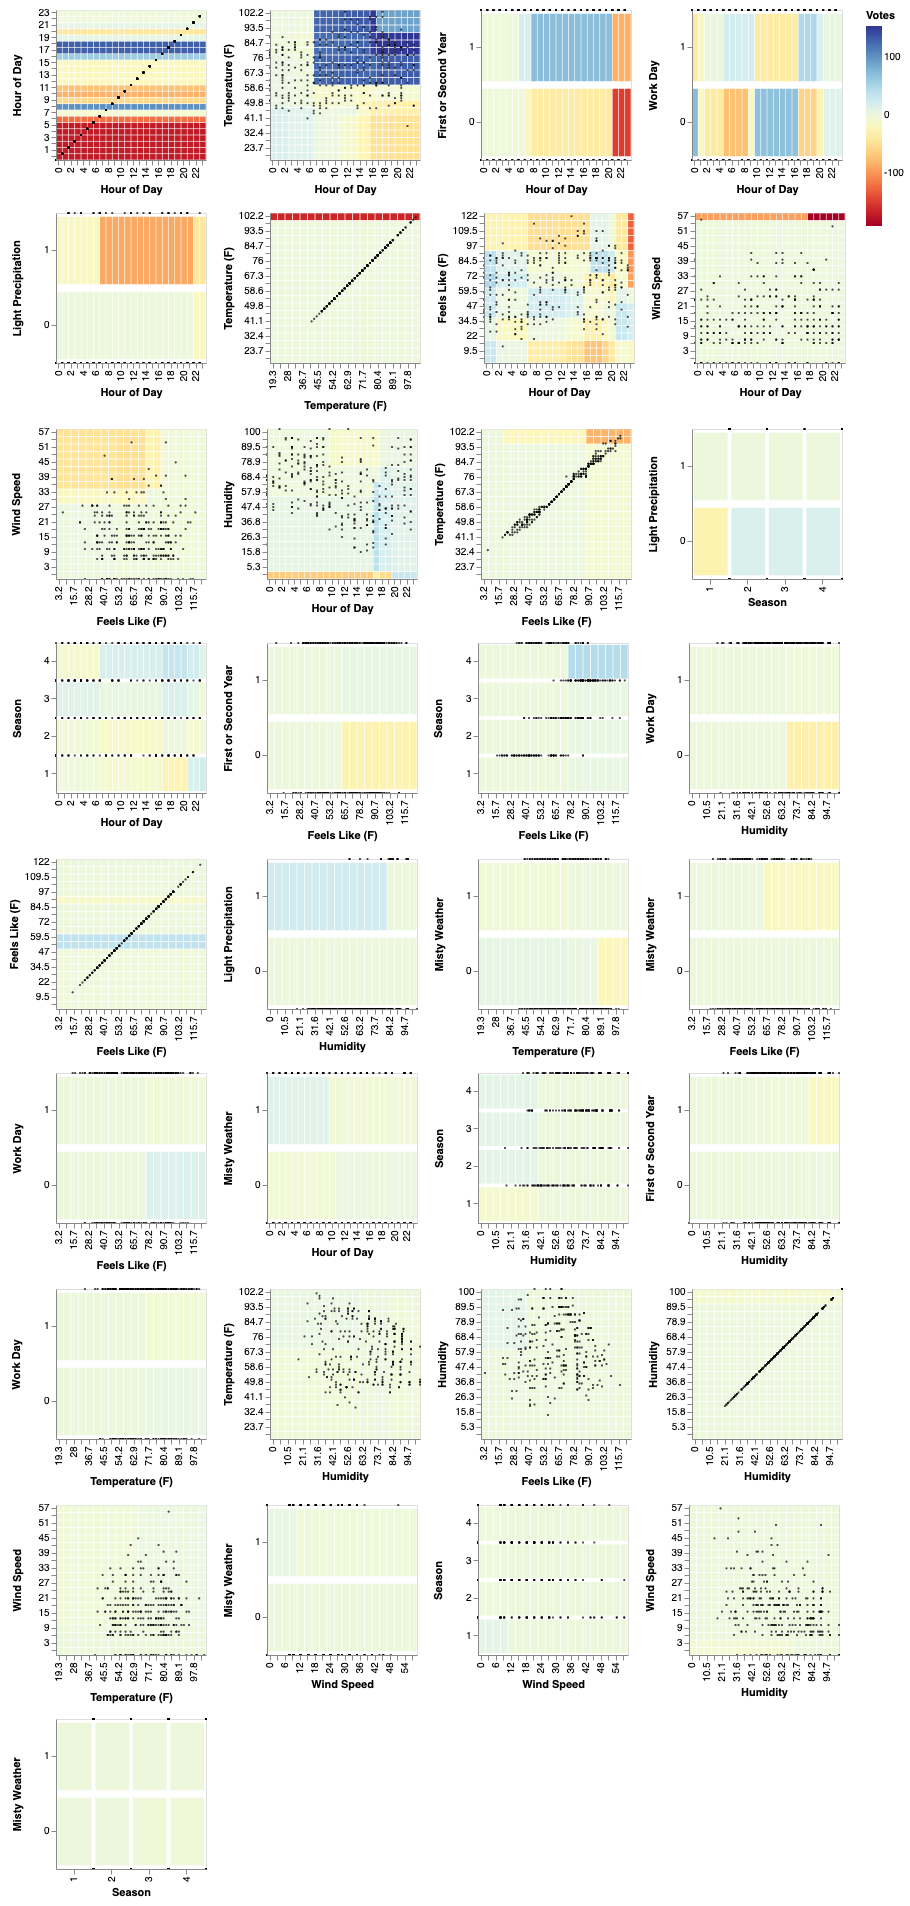

In [824]:
generate_chart(chart_data, data_to_use)

In [ ]:
data_to_use = load_data("cervical cancer")
classifier, accuracy = build_classifier(data_to_use, 300, "random forest")
chart_data, output_details = calculate(data_to_use, True)
generate_chart(chart_data, scheme="greenblue")